<a href="https://colab.research.google.com/github/duhlmann/duhlmann.github.io/blob/main/notebooks/ultrasonic_pulse_echo_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ultrasound Defect Detection (Toy Data)

In [ ]:
# Step 1: Basic setup
import numpy as np
import matplotlib.pyplot as plt

print("Setup complete. Ready to load data!")

Setup complete. Ready to load data!


### First Attempt to Plot a Signal (Error)

Here I first tried to plot the ultrasonic signal directly.  
This attempt produced an error because the data needed to be converted to numeric format.  
I kept this cell in the notebook to show the troubleshooting process.

TypeError: 'value' must be an instance of str or bytes, not a numpy.int64

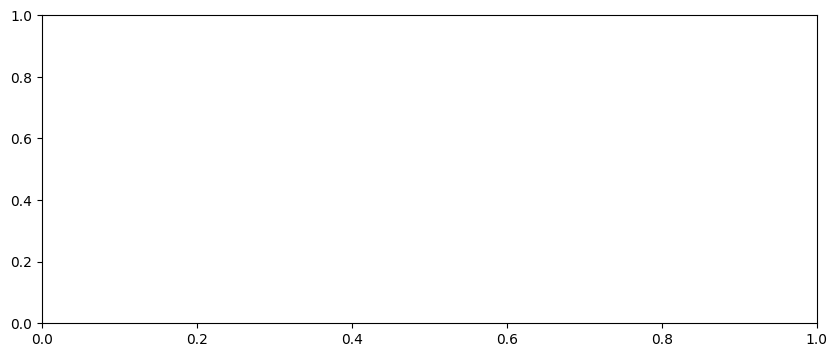

In [ ]:
# Step 6: Plot the first ultrasonic signal trace

plt.figure(figsize=(10,4))
plt.plot(df.iloc[0].values)
plt.title("Ultrasonic Signal Trace (Row 0)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

### Corrected Plot of First Signal

After converting the data to numeric values,  
the ultrasonic signal can now be plotted correctly.  
This shows the time-domain waveform for the first measurement (Row 0).


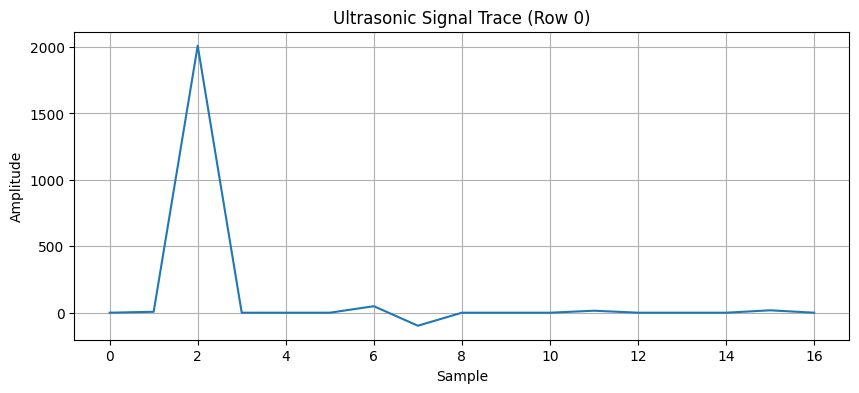

In [ ]:
# Step 6: Coerce to numeric and plot the first signal trace
import numpy as np

# Take the first row and force everything to float numbers
y = pd.to_numeric(df.iloc[0], errors='coerce').to_numpy(dtype=float)

# Replace any NaNs with 0 (safe for a quick look)
y = np.nan_to_num(y)

plt.figure(figsize=(10,4))
plt.plot(y)
plt.title("Ultrasonic Signal Trace (Row 0)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

### Plotting the First 5 Signals (Overlapping)

Here I attempted to plot the first 5 ultrasonic signals on the same chart.  
It works, but since the signals overlap, it is hard to see each one clearly.  
In the next step, I improved this by plotting them in separate subplots.


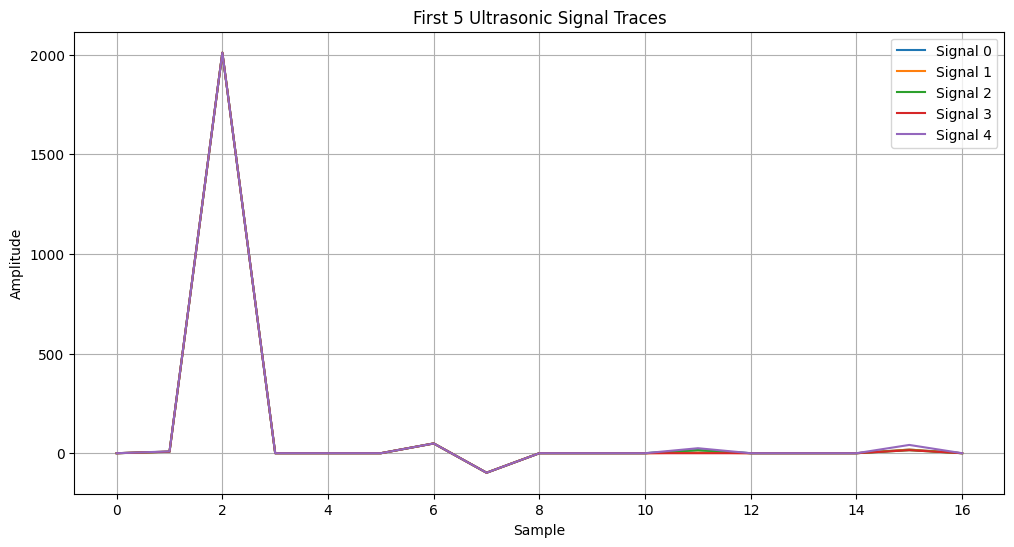

In [ ]:
# Step 7: Plot the first 5 ultrasonic signals

plt.figure(figsize=(12,6))

for i in range(5):
    y = pd.to_numeric(df.iloc[i], errors='coerce').to_numpy(dtype=float)
    y = np.nan_to_num(y)
    plt.plot(y, label=f"Signal {i}")

plt.title("First 5 Ultrasonic Signal Traces")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

### Improved Plot of First 5 Signals (Stacked)

To make the signals easier to compare,  
each of the first 5 ultrasonic traces is shown in its own subplot.  
This stacked view clearly shows the differences between signals without overlap.

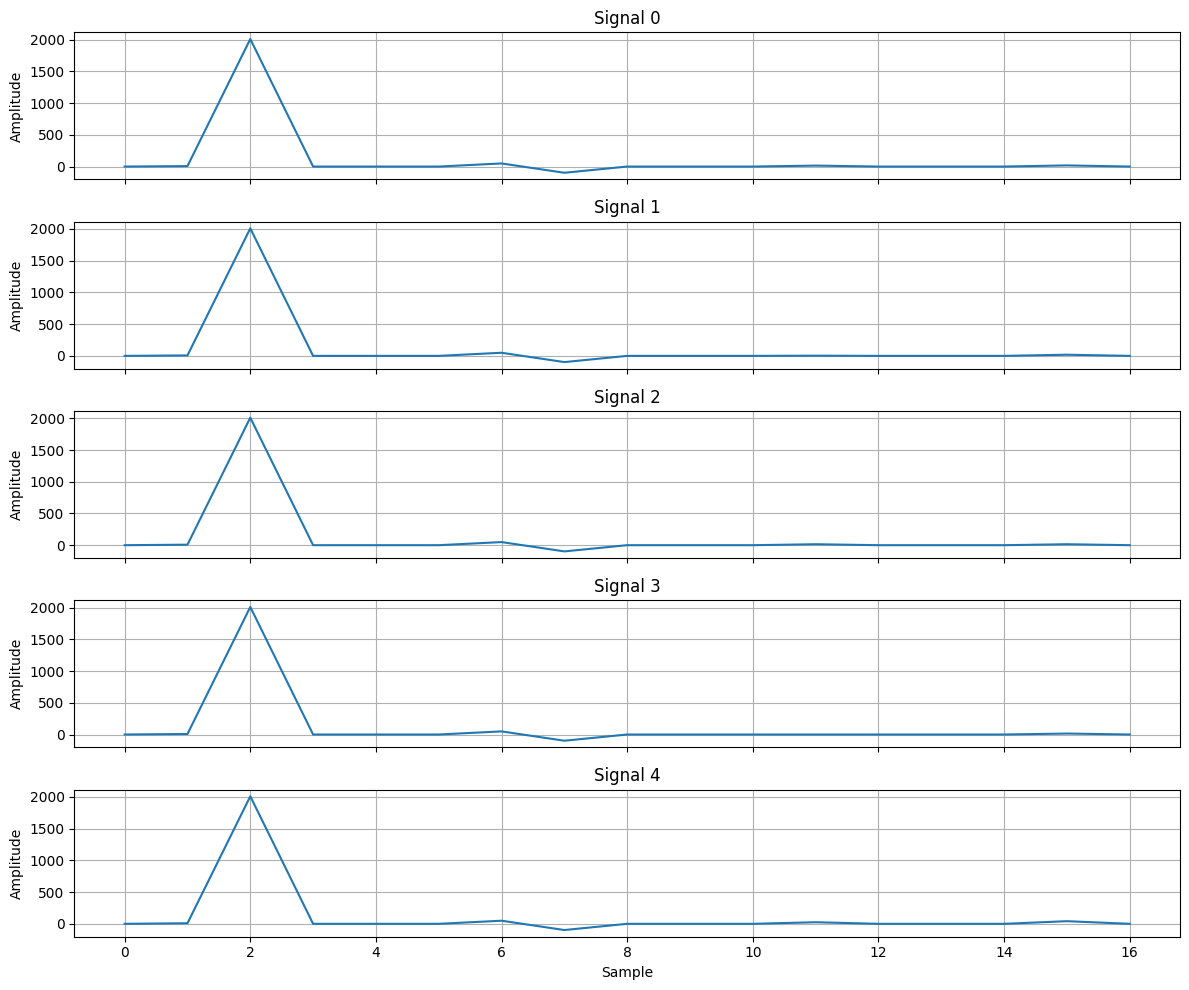

In [ ]:
# Step 7 (improved): Plot the first 5 signals in separate subplots

fig, axes = plt.subplots(5, 1, figsize=(12,10), sharex=True)

for i in range(5):
    y = pd.to_numeric(df.iloc[i], errors='coerce').to_numpy(dtype=float)
    y = np.nan_to_num(y)
    axes[i].plot(y)
    axes[i].set_title(f"Signal {i}")
    axes[i].set_ylabel("Amplitude")
    axes[i].grid(True)

plt.xlabel("Sample")
plt.tight_layout()
plt.show()

## Signal Processing Step: Frequency Analysis (FFT)

Now that we have visualized some ultrasonic signals in the time domain,
we will use the **Fast Fourier Transform (FFT)** to look at their frequency content.  
This helps reveal the dominant frequencies present in the ultrasonic pulses,
which is useful for defect detection and feature extraction.

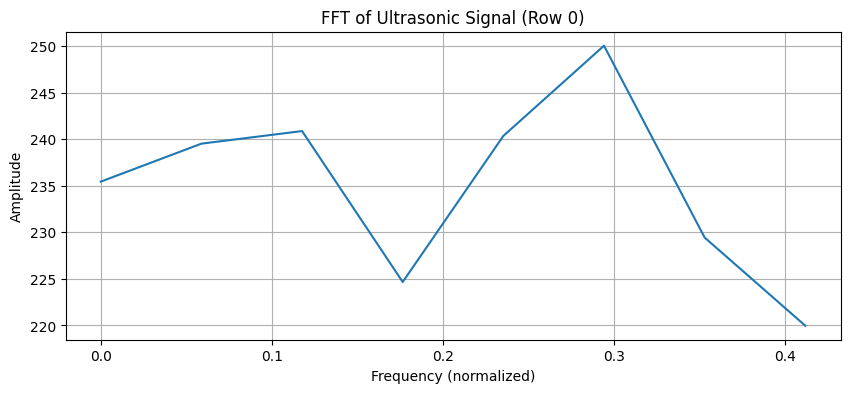

In [ ]:
# Step 8: Compute and plot FFT (frequency spectrum) for one signal

from scipy.fft import fft, fftfreq

# Take one signal (row 0) and convert to numeric
y = pd.to_numeric(df.iloc[0], errors='coerce').to_numpy(dtype=float)
y = np.nan_to_num(y)

# Number of samples
N = len(y)

# Assume sampling rate = 1 (since we don’t have actual time units, just samples)
# -> frequencies will be in "normalized units"
yf = fft(y)
xf = fftfreq(N, 1)[:N//2]  # Only keep positive frequencies

plt.figure(figsize=(10,4))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.title("FFT of Ultrasonic Signal (Row 0)")
plt.xlabel("Frequency (normalized)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

## Time–Frequency View (Spectrogram)

Next, we’ll create a **spectrogram**, which shows how the signal’s frequency content
changes over time. This is useful for turning 1D ultrasonic signals into **2D images**
that a CNN can learn from later.


In [ ]:
# Quick check: how long are the first few rows?

import numpy as np

print("df shape:", df.shape)

for i in range(3):
    y_i = pd.to_numeric(df.iloc[i], errors='coerce').to_numpy(dtype=float)
    y_i = np.nan_to_num(y_i)
    print(f"Row {i}: length = {len(y_i)}, finite values = {np.isfinite(y_i).sum()}")

df shape: (477, 17)
Row 0: length = 17, finite values = 17
Row 1: length = 17, finite values = 17
Row 2: length = 17, finite values = 17


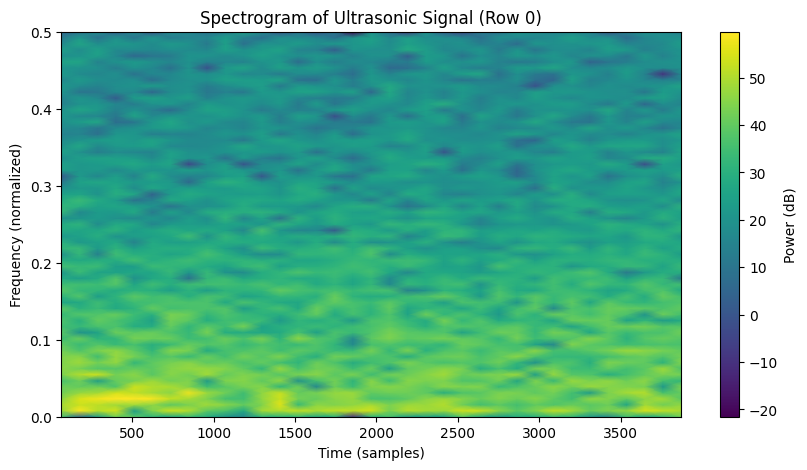

In [ ]:
# Step 9: Simple spectrogram of the first ultrasonic signal

from scipy.signal import spectrogram

# Take the first signal (row 0) and ensure numeric floats
y = pd.to_numeric(df.iloc[0], errors='coerce').to_numpy(dtype=float)
y = np.nan_to_num(y)

# Compute spectrogram with a modest window
f, t, Sxx = spectrogram(y, fs=1.0, nperseg=128)

# Plot as heatmap (dB scale)
plt.figure(figsize=(10,5))
plt.pcolormesh(t, f, 10*np.log10(Sxx + 1e-12), shading='gouraud')
plt.title("Spectrogram of Ultrasonic Signal (Row 0)")
plt.xlabel("Time (samples)")
plt.ylabel("Frequency (normalized)")
plt.colorbar(label="Power (dB)")
plt.show()

### Spectrogram: Turning Sound into Pictures for ML


### Understanding the Spectrogram

The spectrogram shows the ultrasonic signal in both **time** and **frequency**:

- **X-axis (time):** how the pulse evolves across the 4000 samples.  
- **Y-axis (frequency):** which frequency components are present.  
- **Color (intensity):** how strong each frequency is at each moment.  

Why this matters:  
- In the raw waveform (time domain), echoes can overlap and look noisy.  
- In the spectrogram (time–frequency domain), reflections appear as **distinct patches**.  
- These patterns can reveal material properties or hidden defects.  
- Converting ultrasonic signals into spectrograms turns them into **images**, which can be analyzed by CNNs.

In [ ]:
import numpy as np
import pandas as pd

print("df shape:", df.shape)
y = pd.to_numeric(df.iloc[0], errors='coerce').to_numpy(dtype=float)
print("Row 0 samples:", y.size, " | finite:", np.isfinite(y).sum())

df shape: (477, 17)
Row 0 samples: 17  | finite: 6


In [ ]:
# Step X: Upload and load the correct ultrasonic CSV (Long_... or Shear_...)

from google.colab import files
import pandas as pd, numpy as np

# This will open a file picker in Colab
uploaded = files.upload()   # 👉 choose Long_x001-x101_y001_Rot90.csv (or another Long_/Shear_ file)

# Pick the correct file from the upload
choices = [k for k in uploaded.keys() if k.lower().startswith(("long_", "shear_"))]
filename = choices[0] if choices else list(uploaded.keys())[0]

# Load the CSV into a DataFrame
df = pd.read_csv(filename)
print("Loaded:", filename, " | shape:", df.shape)

# Quick sanity check
y0 = pd.to_numeric(df.iloc[0], errors='coerce').to_numpy(dtype=float)
print("Row 0 samples:", y0.size, " | finite:", np.isfinite(y0).sum())

Saving Long_x001-x101_y001_Rot90 (1).csv to Long_x001-x101_y001_Rot90 (1).csv
Loaded: Long_x001-x101_y001_Rot90 (1).csv  | shape: (100, 4000)
Row 0 samples: 4000  | finite: 4000


In [ ]:
!jupyter nbconvert --to html ultrasonic_pulse_echo_ml.ipynb

[NbConvertApp] WARNING | pattern 'ultrasonic_pulse_echo_ml.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
